# TME 7 : Détection d'objets simples (II) :

> Consignes: le fichier TME7_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en TME7_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Commentaires**.

In [1]:
### Chargement des modules et des données utiles.

from PIL import Image
from pylab import *
from scipy.signal import convolve2d
from skimage import morphology
from time import process_time

### charger les images et les convertir en tableaux Numpy
rectangle = array(Image.open("images/rectangle.png"))/255

carrelage = array(Image.open("images/carrelage_wikipedia.jpg"))/255
jussieu = array(Image.open("images/Jussieu_wikipedia.jpg"))/255
house = array(Image.open("images/house2.jpg"))/255
#rotate = array(Image.open("images/rotate.png"))
table = array(Image.open("images/table.png"))/255
chaise = array(Image.open("images/chaise.png"))/255

### image synthétique pour mise au point
def image_contours_ligne_simple():
    """ NoneType -> Array
    Construit une image de contours seuillée de taille 500x500 avec une ligne.
    """
    image_contours = zeros((500,500))
    for t in range(200):
        image_contours[ t + 100, t] = 1
    return image_contours

### Fonctions d'affichage
def affichage_14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
    Dffectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    Paramètres :
      - liste des affichages (entre 1 et 4)
      - liste des titres (entre 1 et 4, autant que de affichages), optionnelle    
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    show()


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
        
    set_xlim((0, image.shape[1]))
    set_ylim((image.shape[0], 0))
    set_axis_off()
    set_title('Cercles détectés')
    show()

### Fonctions de chronométrage
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()


## Exercice 1 — Transformée de Hough: détection de droites

### Question 1 : Calcul de l'accumulateur à partir d'une image de contours, version boucle

On dispose d'une image de contours binarisée. On cherche à calculer la transformée de Hough correspondant.

1. Écrire la fonction ```houghl()``` qui renvoie la transformée de Hough pour les droites de l'image de contours binarisée. On utilisera l'algorithme données en TD. 

La fonction prendra pour arguments:
- l'image de contours: adges, 
- le nombre de pas pour $\theta$: ``ntheta``,
- le nombre de pas pour $\rho$: ``nrho``,
- la tolérance: ``tol`` (qui correspond au test $|x\cos\theta+y\sin\theta-\rho|<tol$).

**Conseil 1:** remplacer le parcours de l'image par une boucle sur les tableaux d'indices ``X`` et ``Y`` des valeurs non nulles de l'image. On utilisera pour cela la fonction Numpy ```nonzero()``` et la fonction Python ```zip()```. 

**Conseil 2:** le calcul des cosinus et sinus est coûteux. En remarquant que les 4 boucles imbriquées sont indépendantes les unes des autres et qu'on peut les permuter,  faire en sorte de ne calculer **qu'une seule fois** les valeurs cosinus et sinus pour chaque élément de l'accumulateur de Hough.

In [2]:
def houghl(I,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    
    def appartient_droite(x,y,cos_theta,sin_theta, rho,tol):
        """float[2]*float*float->boolean"""
        return abs(cos_theta*x+sin_theta*y-rho)<tol

    #Accumulateur H
    H = np.zeros((ntheta,nrho))
    
    #Tableaux d'indices X et Y des valeurs non nulles de l'images à l'aide de la fonction nonzero de Numpy
    Y,X = np.nonzero(I)
    
    #Définition de rho max
    # l'angle theta varie entre 0 et Pi
    #le parametre rho varient de facon a couvrir
    # le domaine de l'image soit [-rmax,+rmax]
    rmax := (I.dimxˆ2+I.dimyˆ2)ˆ0.5;
    dimy,dimx = I.shape
    rmax=math.sqrt(dimx**2+dimy**2)
    
    #Liste des valeurs prises par theta et rho avec les nombres de pas ntheta et nrho donnés
    #linspace (valeurmin, valeurmax, nb de valeurs comprise entre min et max)
    tab_theta=np.linspace(-math.pi/2,math.pi,ntheta)
    tab_rho=np.linspace(0,rmax,nrho)
    
    #zip: assemble 1er élem de X avec 1er élem de Y 2e élem de X et 2e élem de Y etc...
    for (y,x) in zip(Y,X):
        for i_theta in range(ntheta):
            
            theta = tab_theta[i_theta]
            cos_theta = math.cos(theta)
            sin_theta = math.sin(theta)
            
            for i_rho in range(nrho):
                rho = tab_rho[i_rho]
                if I[y,x]>tol:
                    if appartient_droite(x,y,cos_theta,sin_theta,rho,tol):
                        H[i_theta][i_rho]+=1
    return H


2. Tester la fonction ```houghl()``` en l'appliquant à l'image de contours binarisée synthétique très simple générée par la fonction ```image_contours_ligne_simple()```. Afficher l'accumulateur de Hough. Chronométrez également le temps de calcul de la fonction ```hough()```, en prenant des valeurs différentes pour nt et nr. Rappel TD: idéalement nr vaut la longueur d'une diagonale de l'image à traiter et nt pourrait valoir 360 pour avoir une précision de 1 degré, dans un repère polaire. Conseil: essayer d'abord avec des valeurs nettement plus petites, puis augementer les et observer les temps de calcul. Donner un ordre de grandeur de la complexité de cet algorithme.

## Tests en fonction de ntheta

*__Test avec ntheta = 360__*

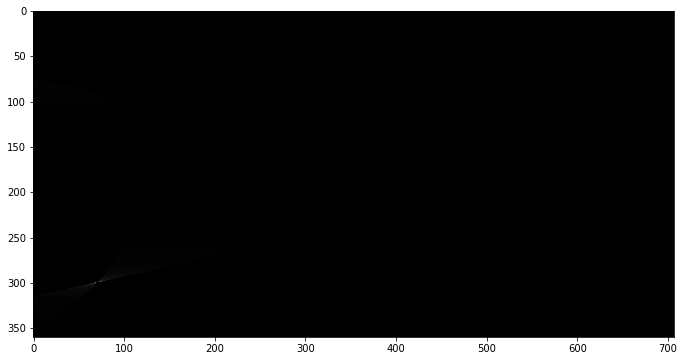

In [3]:
I = image_contours_ligne_simple()

dimy,dimx = I.shape

#précisions en degré
rho= 1.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
#math.floor : le plus grand entier plus petit ou égal.
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)

#classe figure
figure(figsize=(12,6))
#cmap : palette de couleur
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

*__Test avec ntheta = 360/10__*

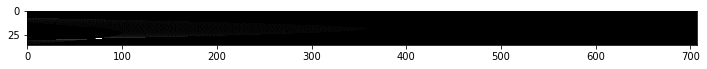

In [4]:
#précisions en degré
rho= 1.0
theta=10

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

*__Test avec ntheta = 360/5__*

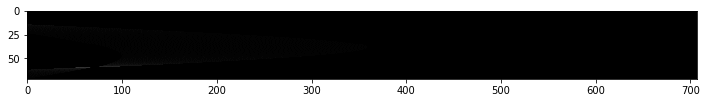

In [5]:
#précisions en degré
rho= 1.0
theta=5

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)

figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

*__Test avec ntheta = 360/2__*

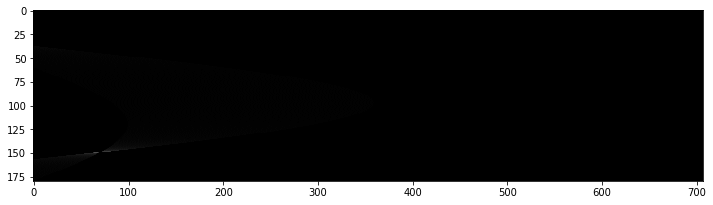

In [6]:
#précisions en degré
rho= 1.0
theta=2

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

__Test de complexité temporelle en fonction de ntheta:__

In [7]:
I=image_contours_ligne_simple()

#précisions en degré
rho= 1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)

#Liste des valeurs prises par ntheta
#reversed pour inverser et commencer à partir de 21
tab_ntheta=[int(360.0/theta) for theta in reversed(range(2,22,2))]


#Calcul du temps d'exécution

temps=[]

for ntheta in tab_ntheta:
    start=process_time()
    houghl(I,ntheta,nrho,0.5)
    end=process_time()
    temps.append(end-start)

In [8]:
print(temps)

[42.039372000000185, 45.78677199999993, 51.72890800000005, 68.54507600000011, 70.42632400000002, 83.91877599999998, 109.00631399999997, 148.6209060000001, 218.40792800000008, 434.841308]


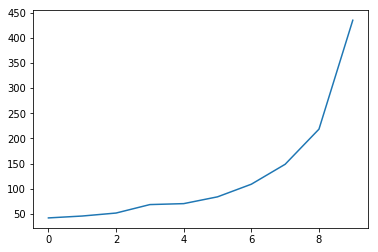

In [9]:
plt.plot(temps)
plt.title=('Temps d\'exécution en fonction de ntheta')

plt.show()

In [ ]:
#Commentaire:

#L'algorithme houghl varie exponentiellement en fonction de ntheta.

### Tests en fonction de nrho

`nrho = int(math.floor(math.sqrt(dimx ** 2+dimy ** 2)) = 707`

__Test avec nrho = 707__

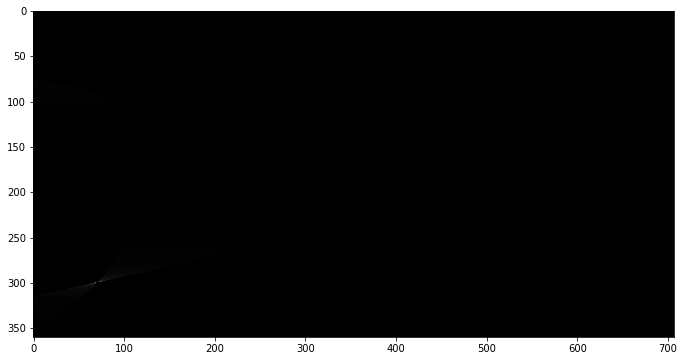

In [10]:
#précisions en degré
rho= 1.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

__Test avec nrho = 707/10__

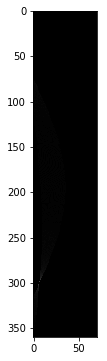

In [11]:
#précisions en degré
rho= 10.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

__Test avec nrho = 707/5__

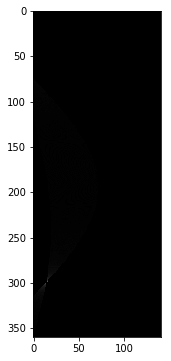

In [12]:
#précisions en degré
rho= 5.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

__Test avec nrho = 707/2__

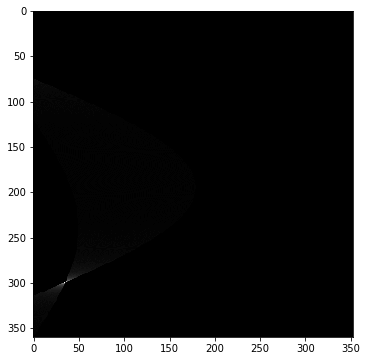

In [13]:
#précisions en degré
rho= 2.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl(I,ntheta,nrho,0.5),cmap=cm.gray)

__Test de complexité temporelle en fonction de nrho:__

In [14]:
I=image_contours_ligne_simple()

#précisions en degré
theta= 1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)

#Liste des valeurs prises par ntheta
tab_nrho=[int(math.floor(math.sqrt(dimx**2+dimy**2))/rho) for rho in reversed(range(2,22,2))]


#Calcul du temps d'exécution

temps=[]

for nrho in tab_nrho:
    start=process_time()
    houghl(I,ntheta,nrho,0.5)
    end=process_time()
    temps.append(end-start)

In [15]:
print(temps)

[55.25551799999994, 54.843893999999636, 55.9818580000001, 72.73838199999955, 93.26245600000038, 100.3593920000003, 106.36467999999968, 141.60037399999965, 220.1032640000003, 461.7585859999999]


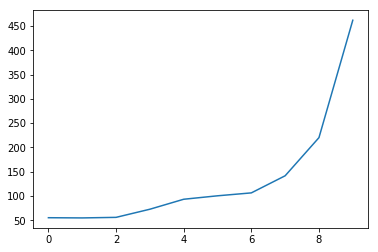

In [16]:

plt.plot(temps)
plt.title=('Temps d\'exécution en fonction de nrho')

plt.show()

In [ ]:
#Commentaire:

#L'algorithme houghl varie également exponentiellement en fonction de nrho.

### Question 2: optimisation de la fonction ``houghl()``

Vous avez du constater que le temps de calcul est très long et cela même pour une image très simple. Le temps dépend donc largement des valeurs ```ntheta``` et ```nrho```.
Puisque les 4 boucles de l'algorithme (boucles sur indice de ligne, de colonne de l'image de contours à traiter, d'angle et de distance à l'origine) sont indépendantes, on peut imbriquer les parcours sur l'image à l'intérieur du parcours de l'accumulateur de Hough.

On pourra alors constater qu'il revient au même de calculer à l'avance les différentes valeurs de $\rho$ et $\theta$ et de les placer dans des tableaux. En effet, écrire :
````
for r in range(nrho):
    for t in range(ntheta):
       calcul sur t, indépendemment de r
       calcul sur r, indépendemment de t
````
revient à écrire:
`````
for r in range(nrho):
    for t in range(ntheta):
        CT[r,t] = f(t)
        CR[r,t] = g(r)
`````
Le calcul des tableaux ``CT`` et ``CR`` peut-être effectué uniquement par appel Numpy **sans utiliser de boucle**: le tableau ``CT`` voit chacune de ses colonnes **identiques** et ``CR`` ses lignes **identiques**. 

1. En utilisant à bon escient les fonctions ``ones()`` et ```linspace()```, puis facultativement ```meshgrid()```, ou encore plus simplement en gardant les boucles, construire les tableaux ```R```, ```C``` et ```S```. Chaque ligne du tableau ```R``` décrit les mêmes suites de valeurs de $\rho$. Chaque colonne des tableaux ```C``` et ```S``` décrivent les mêmes suites de valeurs de $\cos\theta$ et $\sin\theta$. On rappelle que $\rho$ et $\theta$ vérifient l'équation $x\cos\theta + y\sin\theta = \rho$  pour $x$ et $y$ les coordonnées d'un point de contours dans l'image. Pour la version boucle, quelle est la complexité ? Est-elle acceptable pour un script Python ?

In [37]:
I=image_contours_ligne_simple()

dimy,dimx = I.shape

#précisions en degré
rho= 1.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et theta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)

rmax=math.sqrt(dimx**2+dimy**2)


#Construction de R en fonction de nrho et ntheta
ligne_rho=np.linspace(0,rmax,nrho)
R=np.ones((ntheta,nrho))
for ligne in range(len(R)):
    R[ligne]=ligne_rho

#Construction de ligne_theta la liste des valeurs de theta
ligne_theta=np.linspace(-math.pi/2,math.pi,ntheta)

#Construction de C et S en fonction de R
cos_theta=np.cos(ligne_theta)
sin_theta=np.sin(ligne_theta)

colonne_C = [[ct] for ct in cos_theta]
colonne_S = [[st] for st in sin_theta]

C=np.asarray(colonne_C)
S=np.asarray(colonne_S)

for i in range(nrho-1):
    C=np.hstack((C,colonne_C))
    S=np.hstack((S,colonne_S))


2. Soit $(x_1,y_1),..,(x_n,y_n)$ la liste des $n$ points de contours dans l'image de contours binarisée que l'on doit analyser, remarquer alors que $H = \sum_{i=1}^n |x_i C + y_i S - R| <= tol$. En déduire une version 2 de la fonction ``houghl_opt()``. Comparer le temps d'exécution avec la version précédente. 

In [38]:

def houghl_opt(I,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    
    def appartient_droite(x,y,cos_theta,sin_theta, rho,tol):
        """float[2]*float*float->boolean"""
        return abs(cos_theta*x+sin_theta*y-rho)<tol

    #Accumulateur H
    H = np.zeros((ntheta,nrho))
    
    #Tableaux d'indices X et Y des valeurs non nulles de l'images à l'aide de la fonction nonzero de Numpy
    Y,X = np.nonzero(I)
    
    #Définition de rho max
    dimy,dimx = I.shape
    rmax=math.sqrt(dimx**2+dimy**2)
    
    #Liste des valeurs prises par theta et rho avec les nombres de pas ntheta et nrho donnés
    ligne_theta=np.linspace(-math.pi/2,math.pi,ntheta)
    ligne_rho=np.linspace(0,rmax,nrho)
    
    #Construction de R
    R=np.ones((ntheta,nrho))
    for ligne in range(len(R)):
        R[ligne]=ligne_rho
    
    #Construction de S, C
    cos_theta=np.cos(ligne_theta)
    sin_theta=np.sin(ligne_theta)

    #On transforme cos_theta et sin_theta en colonnes
    colonne_C = [[ct] for ct in cos_theta]
    colonne_S = [[st] for st in sin_theta]

    C=np.asarray(colonne_C)
    S=np.asarray(colonne_S)
    
    for i in range(nrho-1):
        C=np.hstack((C,colonne_C))
        S=np.hstack((S,colonne_S))

#on parcourt les pixel de l'image
    for (y,x) in zip(Y,X):
        if I[y,x]>tol:
            tmp = np.abs(x*C+y*S-R)<tol
            H+=tmp.astype(int)
    return H


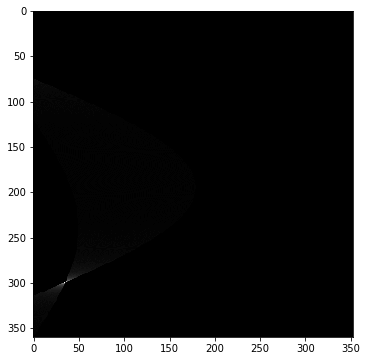

In [39]:
#précisions en degré
rho= 2.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)


figure(figsize=(12,6))
imshow(houghl_opt(I,ntheta,nrho,0.5),cmap=cm.gray)

### TEST DE COMPLEXITE TEMPORELLE

__Temps d'exécution en fonction de ntheta:__

In [41]:
I=image_contours_ligne_simple()

#précisions en degré
theta= 1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)

#Liste des valeurs prises par ntheta
tab_nrho=[int(math.floor(math.sqrt(dimx**2+dimy**2))/rho) for rho in reversed(range(2,22,2))]


#Calcul du temps d'exécution

temps=[]

for nrho in tab_nrho:
    start=process_time()
    houghl_opt(I,ntheta,nrho,0.5)
    end=process_time()
    temps.append(end-start)

In [42]:
print(temps)

[0.0742099999997663, 0.07747399999971094, 0.10162399999990157, 0.10213800000019546, 0.1068119999999908, 0.13366600000063045, 0.15315000000009604, 0.20955599999979313, 0.3929920000000493, 1.1748600000000806]


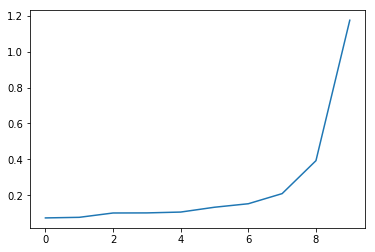

In [43]:

plt.plot(temps)
plt.title=('Temps d\'exécution en fonction de ntheta')

plt.show()

__Temps d'exécution en fonction de nrho:__

In [44]:
I=image_contours_ligne_simple()

#précisions en degré
theta= 1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)

#Liste des valeurs prises par ntheta
tab_nrho=[int(math.floor(math.sqrt(dimx**2+dimy**2))/rho) for rho in reversed(range(2,22,2))]


#Calcul du temps d'exécution

temps=[]

for nrho in tab_nrho:
    start=process_time()
    houghl_opt(I,ntheta,nrho,0.5)
    end=process_time()
    temps.append(end-start)

In [45]:
print(temps)

[0.07858399999986432, 0.07711800000015501, 0.10287800000060088, 0.10031400000025315, 0.10598200000003999, 0.12720600000011473, 0.1542120000003706, 0.20861800000056974, 0.40042600000015227, 1.485049999999319]


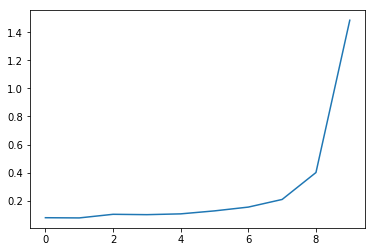

In [46]:

plt.plot(temps)
plt.title=('Temps d\'exécution en fonction de ntheta')

plt.show()

### Question 3 : Recherche des $N$ plus grands maxima locaux

On cherche ici à rechercher les $N$ plus grands maxima locaux de l'accumulateur de Hough afin de déterminer quelles sont les droites détectées.

1. Écrire une fonction ```maxloc_N(H,N)``` qui calcule les ``N`` maxima locaux de l'accumulateur ``H``. La fonction est similaire à celle du TME 6 (```maxloc()```) avec une différence toutefois : elle retourne une liste des coordonnées des ``N`` premiers maxima locaux **trié** par valeurs décroissantes qu'ils prennent dans ```H```. On rappelle que Python possède une fonction ```sorted()``` opérant sur les listes.

In [47]:
def maxloc_N(H, N): 
    """ Array[int]*int -> list[tuple(int,int)] """
    
    dimy,dimx = H.shape
    
    #Matrice des maxima locaux
    max_locaux=np.zeros((dimy,dimx))

    #Liste des indices des N plus grands maxima locaux
    index_max=[]
    
    for x in range(1,dimx-1):
        for y in range(1,dimy-1):
                p = H[y,x]
                #Si p est un maximum local
                if p==np.max(H[y-1:y+2,x-1:x+2]):
                    max_locaux[y,x]=p
                    
    #Choix des N plus grands maxima locaux
    #index_max est trié dans l'ordre décroissant

    while len(index_max)<N:
        arg = np.argmax(max_locaux)
        #calcul de la ligne
        y=arg//dimx
        #calcul de la colonne
        x=arg%dimx
        index_max.append((y,x))
        max_locaux[y,x]=0
        
    return index_max

2. Tester cette fonction sur l'accumulateur calculé à la question 1 (ou 2).

In [49]:
#précisions en degré
rho= 2.0
theta=1.0

#ntheta et nrho en fonction des précisions de rho et ntheta
ntheta = int(360.0/theta)
#idéalement, nrho vaut la longueur d'une diagonale de l'image
nrho = int(math.floor(math.sqrt(dimx**2+dimy**2))/rho)

#Accumulateur H
H=houghl_opt(I,ntheta,nrho,0.5)

#Calcul des maxima locaux
N=100
print('maxloxN(H,10)=',maxloc_N(H,N))

maxloxN(H,10)= [(300, 34), (298, 36), (298, 37), (301, 32), (302, 29), (302, 30), (296, 42), (303, 27), (295, 44), (294, 46), (293, 48), (305, 22), (305, 23), (292, 51), (306, 20), (291, 39), (291, 49), (291, 53), (308, 19), (289, 40), (289, 43), (289, 46), (289, 53), (289, 56), (290, 55), (308, 15), (308, 16), (308, 17), (309, 14), (309, 15), (309, 16), (309, 17), (309, 21), (309, 22), (309, 23), (309, 24), (309, 25), (309, 26), (309, 27), (286, 44), (286, 63), (287, 41), (287, 50), (287, 51), (287, 52), (287, 53), (287, 54), (287, 55), (287, 56), (288, 48), (288, 49), (288, 50), (288, 51), (288, 58), (288, 59), (288, 60), (289, 58), (310, 11), (310, 12), (310, 29), (311, 8), (311, 12), (311, 13), (311, 14), (311, 17), (311, 18), (311, 19), (311, 23), (311, 24), (311, 25), (311, 28), (311, 29), (312, 15), (312, 17), (312, 19), (312, 21), (76, 2), (77, 1), (77, 4), (282, 52), (282, 55), (282, 66), (282, 69), (283, 44), (283, 45), (283, 48), (283, 49), (283, 52), (283, 53), (283, 56), (

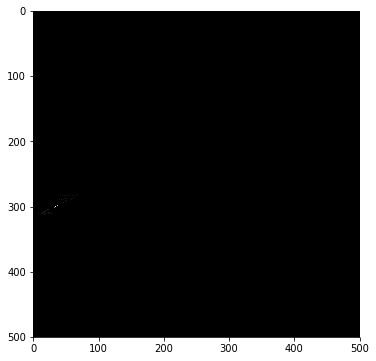

In [50]:
#Affichage graphique des N plus grands maxima locaux
liste_maxloc=maxloc_N(H,N)

maxlocaux_N=np.zeros((dimy,dimx))
for pixel in liste_maxloc:
    y,x = pixel
    maxlocaux_N[y,x]=H[y,x]

figure(figsize=(12,6))
imshow(maxlocaux_N,cmap=cm.gray)

3. Écrire une fonction ``hougl_intersect(l,c,H,I)`` qui calcule l'intersection de la droite de coordonnée ``(l,c)`` dans l'accumulateur ``H`` avec les bords de l'image ``I``. La fonction doit calculer les valeurs $(\rho,\theta)$ correspondant à ``(l,c)`` puis calculer une liste de 4 coordonnées qui correspond aux intersections de la droite  $(\rho,\theta)$ avec les droites $x=0$, $x=m-1$, $y=0$ et $y=m-1$ dans le plan image. La fonction ne retournera que les intersections qui sont dans le plan de l'image (normalement 2) sous forme de deux listes: la première liste donc les indices de colonne, et la seconde, les indices de ligne.

In [51]:
def houghl_intersect(l,c,H,I):
    """ int*int*Array[int]*Array -> tuple[list[int],list[int]] """
    

4. Écrire une fonction ``houghl_draw(H,N,I)`` qui affiche l'image ``I`` et les ``N`` segments de droites correspondant aux $N$ premiers maxima locaux de $H$. Testez là sur l'accumulateur précédent. Si le résultat n'est pas très précis, recalculer l'accumulateur de Hough avec plus de précision.

In [56]:
def  houghl_draw(H,N,I):
    """ Array[int]*int*Array -> NoneType"""
    


In [57]:
H_rectangle=houghl_opt(rectangle,ntheta,nrho,0.5)



### Question 4 : Détection de lignes sur une image.

On cherche maintenant à détecter les lignes dans une image quelconque à l'aide de la méthode de Hough.

1. Écrire une fonction ``edges(I,s)`` qui réalise une détection de contours sur l'image ``I`` à l'aide des opérateurs de Sobel et de la fonction ``convolve2d()``. On effectuera un seuillage binaire sur la norme du gradient, le seuil sera donné par ``s``. Enfin, on utilisera la fonction ```morphology.thin()``` du module ``skimage`` qui permet de réalisé un affinage des contours. La fonction retournera la carte des contours affinés.



In [58]:
def edges(I,s):
    """ Array*float -> Array[bool] """
    Sobel_x=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Sobel_y=np.array([[-1,2,-1],[0,0,0],[1,2,1]])
    
    Ix=convolve2d(I,Sobel_x)
    Iy=convolve2d(I,Sobel_y)
    I2=np.zeros_like(I)
    
    n,m=I.shape
    
    for i in range(n):
        for j in range(m):
            #norme du gradient
            norm=np.linalg.norm([Ix[i,j],Iy[i,j]])
            if norm>s:
                I2[i,j]=1
    #Affinage des contours
    return morphology.thin(I2)


2. Tester la fonction ``edges()`` sur l'image ``rectangle.png``. Afficher l'image des contours binarisée.

3. Calculer et afficher l''accumulateur de Hough pour cette image. On utilisera la version optimisée du détecteur de Hough ainsi que les valeurs ntheta=360 et nrho = longueur diagonale de l'image. Commenter l'aspect de l'accumulateur.

4. Afficher les coordonnées et valeurs des premiers maxima locaux. Pour obtenir un bon résultat, il faut probablement avoir une bonne précision sur les valeurs de $\theta$ pour une tolérance faible (<1), une tolérance trop peu faible implique des détections multiples pour le même segment de droite dans l'image. Reconstruire et afficher les 4 droites détectées dans l'accumulateur.

### Question 5: expérimentation
Tester vos codes sur les images ``carrelage.png``, ``jussieu.png``, ``chaise.png``, ``table.png`` et ``house2.png``.

In [63]:
images = [carrelage,jussieu,chaise,table,house]
titres = ["carrelage","jussieu","chaise","table","house"]

for img,titre in zip(images,titres):
    tic()
    print("Image",titre,"taille",img.shape)
    #Code
    
    tac()


Image carrelage taille (349, 454)
0.0005400000000008731
Image jussieu taille (500, 500)
0.0002700000004551839
Image chaise taille (707, 500)
0.0002699999995456892
Image table taille (500, 500)
0.0002660000000105356
Image house taille (256, 256)
0.0002679999997781124


## Exercice  2 : Détection de cercles (bonus)

Implémentez une détection de cercles par la méthode de Hough en adaptant ce qui a été fait dans l'exercice précédent.

- Vous pourrez restreindre la détection aux cercles de rayon inférieur à rayon_max et supérieur à rayon_min.
- On limitera la détection aux cercles dont le centre est dans l'image.
- Il est nécessaire de normaliser l'accumulateur par le périmètre du cercle pour ne pas favoriser la détection de grands cercles.




In [ ]:
# Données
lune = array(Image.open("images/Lune.png"))
cible = array(Image.open("images/cible.png"))
pieces = array(Image.open("images/pieces.png"))
table = array(Image.open("images/table.png"))
chaise = array(Image.open("images/chaise.png"))
velo = array(Image.open("images/Bicyclette_de_Lawson.png").convert('L'))

# image synthétique 
def cercle_simple():
    """ NoneType -> Array
    Construit l'image 200x200 d'un disque de rayon 20 centré. 
    """
    image_contours = zeros((200,200))
    r = 20
    for angle in arange(0,360)*pi/180:
        x = int(round(r*cos(angle))) + 100
        y = int(round(r*sin(angle))) + 100
        image_contours[x,y] = 1
    return image_contours


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
        
#    set_xlim((0, image.shape[1]))
#    set_ylim((image.shape[0], 0))
    set_axis_off()
    set_title('Cercles détectés')
    show()


In [ ]:
# mise au point sur cette image
cercle = cercle_simple()

def houghc(img, r_min, r_max,tol):
    """ Array[bool]*int*int*float -> Array """
                

def maxloc_houghc(H,N):
    """ Array*int -> list[tuple(int,int,int)]"""
